In [287]:
%matplotlib widget
import gudhi as gd
from gudhi import hera
from gudhi import representations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from numpy.random import default_rng
from sklearn.datasets import fetch_openml
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time

In [288]:
rng = default_rng(seed=42)
#X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#zeros = np.array([x.reshape((28,28)) for x in X[y=='0']])

#ones = np.array([x.reshape((28,28)) for x in X[y=='8']])

In [289]:

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [290]:
def CreateComplex(nPoints, NoiseLevel):
    #t = np.linspace(0.001,nCircles,1000)
    #xs = np.ceil(t)*np.cos(2*np.pi*t)+0.05*rng.random(len(t))
    #ys = np.ceil(t)*np.sin(2*np.pi*t)+0.05*rng.random(len(t))
    sig = 3
    rad = 3*sig
    ker = gkern( l = 2*rad+1 , sig = 3)
    
    xs = rng.integers(low = rad, high = 100-rad, size = nPoints)
    ys = rng.integers(low = rad, high = 100-rad, size = nPoints)

    
    bitmap = np.zeros((100,100))
    
    for i in range(nPoints):
        for j in range(-rad, rad+1):
            for k in range(-rad,rad+1):
                bitmap[xs[i]+j][ys[i]+k] = bitmap[xs[i]+j][ys[i]+k] + ker[rad+j][rad+k]

        
    #return bitmap
    offset = 64
    
    bitmap = bitmap-np.min(bitmap)
    bitmap = bitmap / np.max(bitmap)
    bitmap = 2*bitmap+offset
    noise = np.zeros_like(bitmap)
    for i in range(0,NoiseLevel):
        x = rng.integers(low=1, high = 99)
        y = rng.integers(low=1, high = 99)
        bitmap[x,y]=offset+(offset-1)*(2*rng.random()-1)
        bitmap[x+1,y] = 0
        bitmap[x+1,y-1] = 0
        bitmap[x,y-1] = 0
        bitmap[x-1,y-1] = 0
        bitmap[x-1,y] = 0
        bitmap[x-1,y+1] = 0
        bitmap[x,y+1] = 0
        bitmap[x+1,y+1] = 0
    #noise = np.random.choice([0, 1], size=bitmap.shape, p=[1-NoiseLevel, NoiseLevel])
    #noise = noise * (rng.exponential(scale=1.0, size=bitmap.shape)+2)
    #noise=noise*5
    #bitmap = bitmap + noise
    #bitmap = bitmap-np.min(bitmap)
    #bitmap = bitmap / np.max(bitmap)
    return bitmap

In [312]:
def CreatePD(nPoints, NoiseLevel):
    cplx = CreateComplex(nPoints,NoiseLevel)
    cc = gd.CubicalComplex(dimensions = list(cplx.shape),top_dimensional_cells = np.reshape(cplx,-1))

    cc.compute_persistence()

    PD = cc.persistence_intervals_in_dimension(0)
    return PD

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
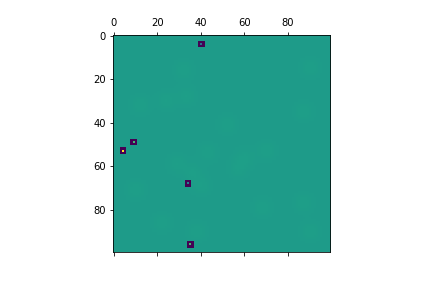

In [313]:
cplx = CreateComplex(20,5)
f,ax = plt.subplots()
ax.matshow(cplx)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
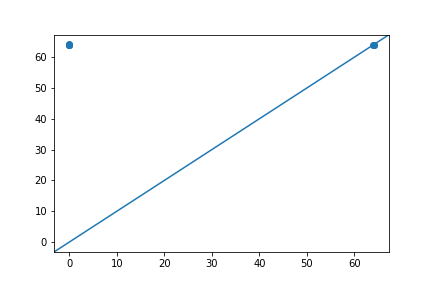

[[ 0.         64.        ]
 [ 0.         64.        ]
 [64.         64.00013067]
 [ 0.         64.00198801]
 [64.00892899 64.0102826 ]
 [64.02225375 64.03670115]
 [ 0.         64.102487  ]
 [ 0.                 inf]]


In [314]:
PD = CreatePD(20,5)
f,ax = plt.subplots()
ax.axline((0,0),slope=1)
ax.scatter(PD[:,0], PD[:,1])
#ax.set_xlim((0,1.1))
#ax.set_ylim((0,1.1))
plt.show()
print(PD)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
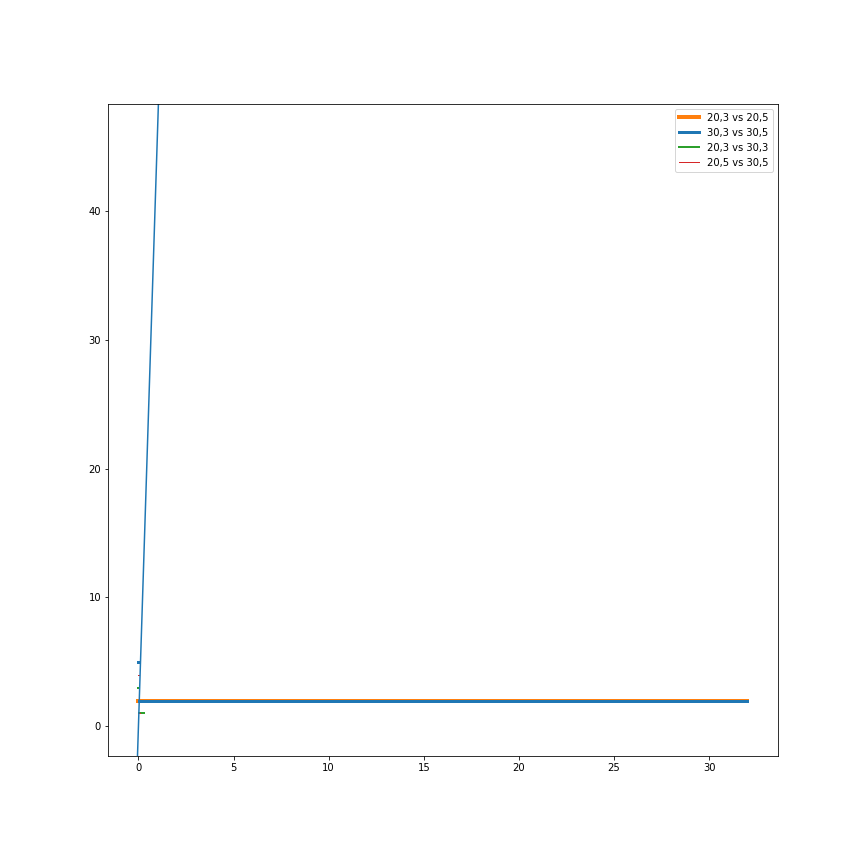

In [315]:
#5 features
PD11 = CreatePD(20,3)
PD12 = CreatePD(20,5)

#2 features
PD21 = CreatePD(30,3)
PD22 = CreatePD(30,5)

#r= np.linspace(0,1,1000)
#bp11 = np.array([gd.bottleneck_profile(PD11,PD12, r0) for r0 in r])
#bp22 = np.array([gd.bottleneck_profile(PD21,PD22, r0) for r0 in r])
#bp12 = np.array([gd.bottleneck_profile(PD11,PD21, r0) for r0 in r])
#bp21 = np.array([gd.bottleneck_profile(PD12,PD22, r0) for r0 in r])

n_points = 2*max([len(PD11),len(PD12),len(PD21),len(PD22)])
d_vals = np.linspace(0,n_points,n_points+1)

r_vals11 = [gd.prokhorov_distance(PD11, PD12, np.array([r])) for r in d_vals]
r_vals22 = [gd.prokhorov_distance(PD21, PD22, np.array([r])) for r in d_vals]
r_vals12 = [gd.prokhorov_distance(PD11, PD21, np.array([r])) for r in d_vals]
r_vals21 = [gd.prokhorov_distance(PD12, PD22, np.array([r])) for r in d_vals]

f,ax=plt.subplots(figsize=(12,12))
#ax.plot(r,bp11, label = "5 vs 5 points")
#ax.plot(r,bp22, label = "2 vs 2 points")
#ax.plot(r,bp12, label = "5 vs 2 points")
#ax.plot(r,bp21, label = "5 vs 2 points")
for i in range(1,n_points+1):
    ax.plot((r_vals11[i],r_vals11[i-1]),(i, i), c='tab:orange', ls='-', linewidth = 4.0, label = '20,3 vs 20,5')
    ax.plot((r_vals22[i],r_vals22[i-1]),(i, i), c='tab:blue', ls='-', linewidth = 3.0, label = '30,3 vs 30,5')
    ax.plot((r_vals12[i],r_vals12[i-1]),(i, i), c='tab:green', ls='-', linewidth = 2.0, label = '20,3 vs 30,3')
    ax.plot((r_vals21[i],r_vals21[i-1]),(i, i), c='tab:red', ls='-', linewidth = 1.0, label = '20,5 vs 30,5')


#ax.set_ylim((-1,12))
#ax.set_xlim((-0.05,0.1))
plt.axline((0,0),(1,46))

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
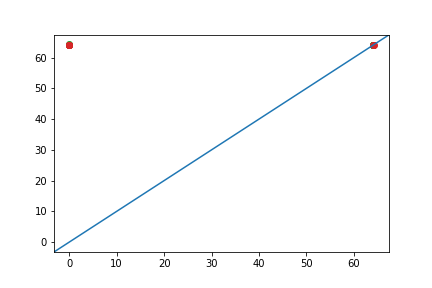

In [316]:
f,ax = plt.subplots()
ax.scatter(PD11[:,0], PD11[:,1])
ax.scatter(PD12[:,0], PD12[:,1])
ax.scatter(PD21[:,0], PD21[:,1])
ax.scatter(PD22[:,0], PD22[:,1])


plt.axline((0,0),slope=1.0)
plt.show()

In [317]:
print(gd.bottleneck_distance(PD11,PD12))
print(gd.bottleneck_distance(PD21,PD22))
print(gd.bottleneck_distance(PD11,PD21))
print(gd.bottleneck_distance(PD12,PD22))

32.00106788686797
32.001889170192456
0.2928809026916781
0.07013341126896933


In [318]:
print(gd.hera.wasserstein_distance(PD11,PD12, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD21,PD22, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD11,PD21, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD12,PD22, order = 1, internal_p=1))


128.21327156984063
128.18195067355444
0.3373034203006142
0.10908896608655994


In [319]:
n_samples = 50
n_gaussians1 = 20
n_gaussians2 = 15
n_noise1 = 3
n_noise2 = 5
PDs = []
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians1,n_noise1))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians1,n_noise2))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians2,n_noise1))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians2,n_noise2))
    
y = [i//(2*n_samples) for i in range(0,len(PDs))]

In [321]:

X_train, X_test, y_train, y_test = train_test_split(PDs, y, test_size=0.4, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric = "precomputed")


In [322]:
tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs=-1)
BD.fit(X_train)
B_train = BD.transform(X_train)
B_test = BD.transform(X_test)
print("Bottleneck done in ", time.time()-tic)
knn.fit(B_train, y_train)
cv_scores = cross_val_score(knn, B_train, y_train, cv=5)
print("Bottleneck training accuracy: ",np.mean(cv_scores))
score = knn.score(B_test, y_test)
print("Bottleneck test accuracy: ",score)

Bottleneck done in  1.1282293796539307
Bottleneck training accuracy:  0.6
Bottleneck test accuracy:  0.55


In [323]:
tic = time.time()
W1D = gd.representations.WassersteinDistance(n_jobs=-1, order=1, internal_p =1)
W1D.fit(X_train)
W1_train = W1D.transform(X_train)
W1_test = W1D.transform(X_test)
print("1-Wasserstein done in ", time.time()-tic)
knn.fit(W1_train, y_train)
cv_scores = cross_val_score(knn, W1_train, y_train, cv=5)
print("1-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W1_test, y_test)
print("1-Wasserstein test accuracy: ",score)

1-Wasserstein done in  0.6035330295562744
1-Wasserstein training accuracy:  0.5833333333333333
1-Wasserstein test accuracy:  0.5875


In [324]:
tic = time.time()
W2D = gd.representations.WassersteinDistance(n_jobs=-1, order=2, internal_p =2)
W2D.fit(X_train)
W2_train = W2D.transform(X_train)
W2_test = W2D.transform(X_test)
print("2-Wasserstein done in ", time.time()-tic)
knn.fit(W2_train, y_train)
cv_scores = cross_val_score(knn, W2_train, y_train, cv=5)
print("2-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W2_test, y_test)
print("2-Wasserstein test accuracy: ",score)

2-Wasserstein done in  1.3809597492218018
2-Wasserstein training accuracy:  0.5416666666666667
2-Wasserstein test accuracy:  0.6


In [325]:
slopes = np.linspace(10,150, 141)
argmax = 0
maxi = 0

for s in slopes:
    PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs = np.array([0,s]))
    PD.fit(X_train)
    P_train = PD.transform(X_train)
    knn.fit(P_train, y_train)
    cv_scores = cross_val_score(knn, P_train, y_train, cv=5)
    print(s, np.mean(cv_scores))
    if(np.mean(cv_scores)>maxi):
        argmax = s
        maxi = np.mean(cv_scores)
        
print("best slope: ",argmax)

10.0 0.5416666666666667
11.0 0.5416666666666666
12.0 0.55
13.0 0.575
14.0 0.5333333333333333
15.0 0.5166666666666667
16.0 0.5333333333333333
17.0 0.5833333333333333
18.0 0.5666666666666667
19.0 0.5583333333333333
20.0 0.5666666666666667
21.0 0.6083333333333333
22.0 0.5333333333333334
23.0 0.5333333333333333
24.0 0.4916666666666667
25.0 0.5416666666666667
26.0 0.5833333333333333
27.0 0.5416666666666666
28.0 0.525
29.0 0.5499999999999999
30.0 0.5416666666666667
31.0 0.5583333333333333
32.0 0.5666666666666667
33.0 0.5333333333333333
34.0 0.5
35.0 0.5333333333333333
36.0 0.5333333333333333
37.0 0.5666666666666667
38.0 0.575
39.0 0.575
40.0 0.5583333333333333
41.0 0.5583333333333333
42.0 0.575
43.0 0.55
44.0 0.5583333333333333
45.0 0.5583333333333333
46.0 0.5166666666666667
47.0 0.5416666666666666
48.0 0.4916666666666667
49.0 0.5166666666666667
50.0 0.5166666666666667
51.0 0.4916666666666666
52.0 0.525
53.0 0.5916666666666667
54.0 0.5666666666666667
55.0 0.55
56.0 0.5666666666666667
57.0 0.

In [326]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs=-1, coefs = np.array([0,argmax]))
PD.fit(X_train)
P_train = PD.transform(X_train)
P_test = PD.transform(X_test)
print("Prokhorov done in ", time.time()-tic)
cv_scores = cross_val_score(knn, P_train, y_train, cv=5)
print("Prokhorov training accuracy: ",np.mean(cv_scores))
score = knn.score(P_test, y_test)
print("Prokhorov test accuracy: ",score)

Prokhorov done in  0.6402537822723389
Prokhorov training accuracy:  0.6083333333333333
Prokhorov test accuracy:  0.5375
